In [ ]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

# Video classification

Video classification is the task of assigning a label or class to an entire video. Videos are expected to have only one class for each video. Video classification models take a video as input and return a prediction about which class the video belongs to. These models can be used to categorize what a video is all about. A real-world application of video classification is action / activity recognition, which is useful for fitness applications. It is also helpful for vision-impaired individuals, especially when they are commuting.

In this notebook we will:

1. Fine-tune [VideoMAE](https://huggingface.co/docs/transformers/main/en/model_doc/videomae) on our (or yours) Arabic Sign Language Dataset.
2. Use our fine-tuned model for inference.

<Tip>
The task illustrated in this notebook is could be expiremented with by the following model architectures:

<!--This tip is automatically generated by `make fix-copies`, do not fill manually!-->

[TimeSformer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/timesformer), [VideoMAE](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/videomae)

<!--End of the generated tip-->

</Tip>

Before we begin, we make sure we have all the necessary libraries installed:

```bash
pip install -q pytorchvideo transformers evaluate
```

We will use [PyTorchVideo](https://pytorchvideo.org/) (dubbed `pytorchvideo`) to process and prepare the videos.

We will log in to a Hugging Face account so we can upload and share our model with the community. When prompted, enter your token to log in:

In [ ]:
!pip install -q pytorchvideo transformers datasets evaluate

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Load our dataset

We start by loading our dataset. This will give us a chance to experiment and make sure everything works before spending more time training on the full dataset.

In [ ]:
import pathlib
dataset_root_path = "/kaggle/input/arslvideodataset"
dataset_root_path = pathlib.Path(dataset_root_path)

video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.mp4")))
video_total = video_count_train + video_count_val
print(f"Total videos: {video_total}")

all_video_file_paths = (
list(dataset_root_path.glob("train/*/*.mp4"))
+ list(dataset_root_path.glob("val/*/*.mp4"))
)
all_video_file_paths[0]

Total videos: 551


PosixPath('/kaggle/input/arslvideodataset/train/I am sorry/Copy of انا اسف 1 (1) (1).mp4')

At a high level, the dataset should be organized like so:

```bash
dataset/
    train/
        BandMarching/
            video_1.mp4
            video_2.mp4
            ...
        Archery
            video_1.mp4
            video_2.mp4
            ...
        ...
    val/
        BandMarching/
            video_1.mp4
            video_2.mp4
            ...
        Archery
            video_1.mp4
            video_2.mp4
            ...
        ...
    test/
        BandMarching/
            video_1.mp4
            video_2.mp4
            ...
        Archery
            video_1.mp4
            video_2.mp4
            ...
        ...
```

The (`sorted`) video paths appear like so:

```bash
...
'dataset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c04.avi',
'dataset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c06.avi',
'dataset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi',
'dataset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g09_c02.avi',
'dataset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g09_c06.avi'
...
```



For the validation and evaluation splits, we wouldn't want to have video clips from the same group / scene to prevent [data leakage](https://www.kaggle.com/code/alexisbcook/data-leakage).

Next up, we will derive the set of labels present in the dataset. Also, create two dictionaries that'll be helpful when initializing the model:

* `label2id`: maps the class names to integers.
* `id2label`: maps the integers to class names.

In [ ]:
class_labels = sorted({str(path).split("/")[5] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['Alhamdulillah', 'Good bye', 'Good evening', 'Good morning', 'How are you', 'I am fine', 'I am pleased to meet you', 'I am sorry', 'Not bad', 'Salam aleikum', 'Sorry', 'Thanks'].


There are 12 unique classes. For each class, there are 40 videos in the training set.

## Load a model to fine-tune

Instantiate a video classification model from a pretrained checkpoint and its associated image processor. The model's encoder comes with pre-trained parameters, and the classification head is randomly initialized. The image processor will come in handy when writing the preprocessing pipeline for our dataset.

In [ ]:
from transformers import AutoImageProcessor, VideoMAEForVideoClassification

model_ckpt= "MCG-NJU/videomae-base-finetuned-kinetics"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

2024-06-21 17:36:34.620071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 17:36:34.620181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 17:36:34.757452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-small-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 384]) in the checkpoint and torch.Size([12, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


While the model is loading, you might notice the following warning:

```bash
Some weights of the model checkpoint at MCG-NJU/videomae-base were not used when initializing VideoMAEForVideoClassification: [..., 'decoder.decoder_layers.1.attention.output.dense.bias', 'decoder.decoder_layers.2.attention.attention.key.weight']
- This IS expected if you are initializing VideoMAEForVideoClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VideoMAEForVideoClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

The warning is telling us we are throwing away some weights (e.g. the weights and bias of the `classifier` layer) and randomly initializing some others (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.


## Prepare the datasets for training

For preprocessing the videos, you will leverage the [PyTorchVideo library](https://pytorchvideo.org/). Start by importing the dependencies we need.

In [ ]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
    AugMix,
    RandAugment
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
    CenterCrop,
    RandomRotation,
    RandomGrayscale,
    RandomPerspective,
    v2
)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


For the training dataset transformations, use a combination of uniform temporal subsampling, pixel normalization, random cropping, and any other transformation you dinf to be approbriate for your usecase. For the validation and evaluation dataset transformations, keep the same transformation chain except for the ones that would be rare in an inference scenario. To learn more about the details of these transformations check out the [official documentation of PyTorchVideo](https://pytorchvideo.org).  

Use the `image_processor` associated with the pre-trained model to obtain the following information:

* Image mean and standard deviation with which the video frame pixels will be normalized.
* Spatial resolution to which the video frames will be resized.

Start by defining some constants.

In [ ]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps
num_frames_to_sample,clip_duration

(16, 2.1333333333333333)

Now, define the dataset-specific transformations and the datasets respectively. Starting with the training set:

In [ ]:
import os

In [ ]:
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    CenterCrop(resize_to),
                    RandomRotation((0,20)),
                    RandomPerspective(),
                ]
            ),
        ),
    ]
)

train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

The same sequence of workflow can be applied to the validation or evaluation sets:

In [ ]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    CenterCrop(resize_to)
                ]
            ),
        ),
    ]
)

val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

**Note**: The above dataset pipelines are taken from the [official PyTorchVideo example](https://pytorchvideo.org/docs/tutorial_classification#dataset). We're using the [`pytorchvideo.data.Ucf101()`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.Ucf101) function because it's tailored for the UCF-101 dataset. Under the hood, it returns a [`pytorchvideo.data.labeled_video_dataset.LabeledVideoDataset`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.LabeledVideoDataset) object. `LabeledVideoDataset` class is the base class for all things video in the PyTorchVideo dataset. So, if you want to use a custom dataset not supported off-the-shelf by PyTorchVideo, you can extend the `LabeledVideoDataset` class accordingly. Refer to the `data` API [documentation to](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html) learn more. Also, if your dataset follows a similar structure (as shown above), then using the `pytorchvideo.data.Ucf101()` should work just fine.

You can access the `num_videos` argument to know the number of videos in the dataset.

In [ ]:
print(train_dataset.num_videos, val_dataset.num_videos)

479 72


## Visualize the preprocessed video for better debugging

In [ ]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)


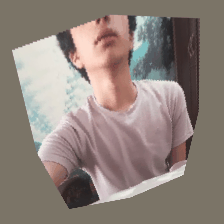

In [ ]:
sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

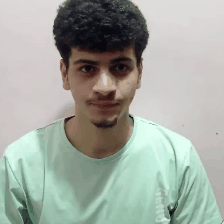

In [ ]:
sample_val_video = next(iter(val_dataset))
val_video_tensor = sample_val_video["video"]
display_gif(val_video_tensor)

## Train the model

Leverage [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) from  🤗 Transformers for training the model. To instantiate a `Trainer`, we need to define the training configuration and an evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to configure the training. It requires an output folder name, which will be used to save the checkpoints of the model. It also helps sync all the information in the model repository on 🤗 Hub.

Most of the training arguments are self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in this case, you need the unused features ('video' in particular) in order to create `pixel_values` (which is a mandatory key our model expects in its inputs).

# If you're using colab
make sure you install accelerate and restart your session to be able to initialize a trainer object

In [ ]:
!pip install accelerate -U

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = "VideoMAE-small-finetuned-ARSL-diverse-dataset"
num_epochs = 3
batch_size=1

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2.5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

The dataset returned by `pytorchvideo.data.Ucf101()` doesn't implement the `__len__` method. As such, we must define `max_steps` when instantiating `TrainingArguments`.

Next, we need to define functions to compute the metrics from the predictions, which will use the `metric` we'll load now. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [ ]:
import evaluate

metric = evaluate.load("accuracy")
confusion_metric = evaluate.load("confusion_matrix")


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def compute_confusion(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return confusion_metric.compute(predictions=predictions, references=eval_pred.label_ids)

**A note on evaluation**:

In the [VideoMAE paper](https://arxiv.org/abs/2203.12602), the authors use the following evaluation strategy. They evaluate the model on several clips from test videos and apply different crops to those clips and report the aggregate score. However, in the interest of simplicity and brevity, we don't consider that in this tutorial.

Also, define a `collate_fn`, which will be used to batch examples together. Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [ ]:
def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then you just pass all of this along with the datasets to `Trainer`:

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


You might wonder why you passed along the `image_processor` as a tokenizer when you preprocessed the data already. This is only to make sure the image processor configuration file (stored as JSON) will also be uploaded to the repo on the Hub.

Now fine-tune our model by calling the `train` method:

In [ ]:
import torch

In [ ]:
train_results = trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
0,2.289900,2.209580,0.168539
1,1.723800,1.309786,0.865169
2,0.766300,0.786296,0.910112
3,0.653600,0.553346,0.966292
4,0.690200,0.504514,0.966292


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [ ]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/mohamedsaeed823/VideoMAE-small-finetuned-ARSL-diverse-dataset/commit/6650e9be06cadd7bfbe4345951f33fb473050810', commit_message='End of training', commit_description='', oid='6650e9be06cadd7bfbe4345951f33fb473050810', pr_url=None, pr_revision=None, pr_num=None)

and we can also get a confusion matrix from our trainer object

In [ ]:
trainer.compute_metrics=compute_confusion

In [ ]:
trainer.evaluate(eval_dataset=val_dataset)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Trainer is attempting to log a value of "[[ 5  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  8  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  7  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  6]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.5584360957145691,
 'eval_confusion_matrix': array([[ 5,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
        [ 0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  2,  8,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6]]),
 'eval_runtime': 154.038,
 'eval_samples_per_second': 0.578,
 'eval_steps_per_second': 0.292,
 'epoch': 4.17}

## Inference

Great, now that you have fine-tuned a model, you can use it for inference!

Load a video for inference:

In [ ]:
sample_test_video = next(iter(test_dataset))

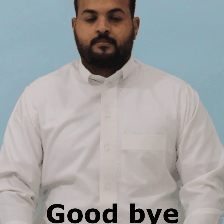

In [ ]:
video_tensor = sample_test_video["video"]
display_gif(video_tensor)

In [ ]:
!pip install decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 54.4 MB/s eta 0:00:0000:0100:01


In [ ]:
from transformers import pipeline

video_cls = pipeline(model="username/modelrepo")

In [ ]:
videocls("video/local/path", sampling_rate=4) # make sure to set your sample rate the same as you did in training, it pivotal to the model performence and confindence

We can also manually replicate the results of the `pipeline` if we'd like.

In [ ]:
def run_inference(model, video):
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)
    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits